In [2]:
import numpy as np
import cvxpy as cp
from matplotlib import pyplot as plt
from Environment import SpringMass
from Subroutines import ModelEst,RobustCE,ApproxDAP,max_norm,OMEGA,M_mid
from time import time
from controllers import SafeDAP
from scipy.linalg import sqrtm
%load_ext autoreload
%autoreload 2

# Find a highly stable spring-mass system

Spectral radius of A: 0.950969590577841 0.4146489883634611 0.9980332767984792
Step 0
Step 100
Step 0
Step 100


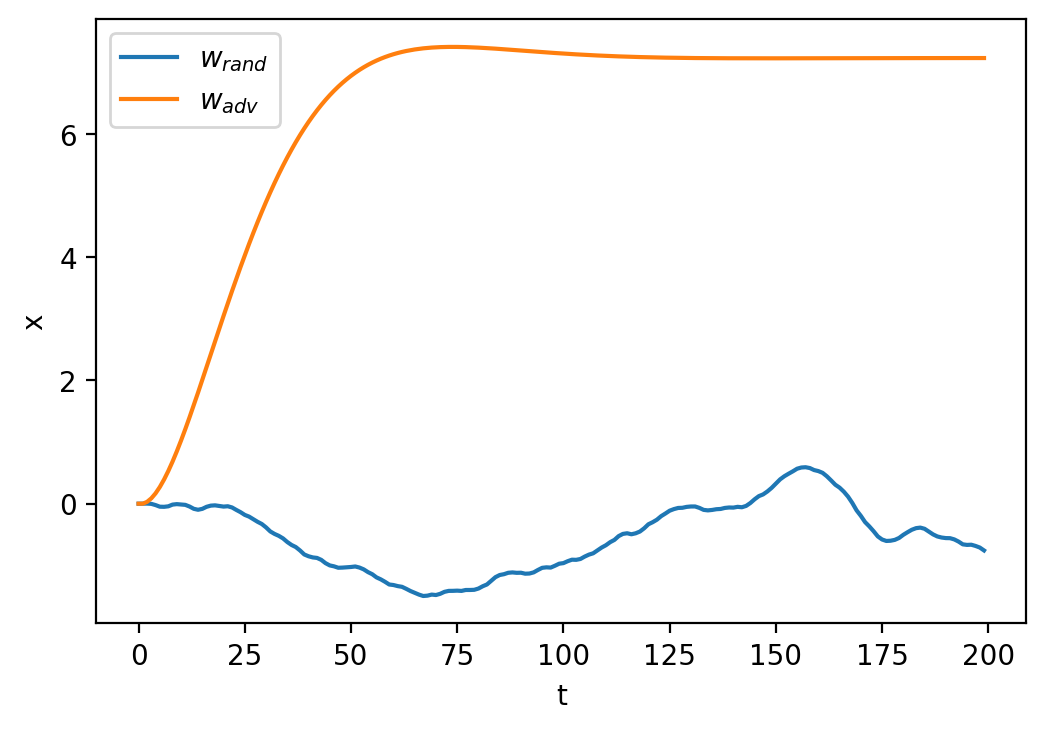

In [3]:
def evaluate(space_dim,dt,K_m_dt,l_m_dt):
    O = np.zeros((space_dim,space_dim))
    I = np.eye(space_dim)

    A = np.vstack([np.hstack([O,dt*I]),
                   np.hstack([-K_m_dt*I,-l_m_dt*I])]) + np.eye(2*space_dim)

    return  np.max(np.abs(np.linalg.eigvals(A)))

dt = 0.1
space_dim = 1
m = 1

candidate_param = np.random.rand(1000,2) * 0.1
istar = np.argmin([evaluate(space_dim,dt,K_m_dt,l_m_dt) for (K_m_dt,l_m_dt) in candidate_param])

K_star, l_star = candidate_param[istar]


K_star,l_star

K = K_star * m/dt

l = l_star*m/dt

print('Spectral radius of A:',evaluate(space_dim,dt,K_star,l_star),K,l)

x_0 = np.array([0,0]).reshape(-1,1)
time_steps = 200

env = SpringMass(x_0 = x_0,m=m,K_stab = K,l=l,w_adv_fraction=0)


x_rand_disturbance = []
# main loop
for _ in range(time_steps):
    x = env.state()
    u = 0 
        
    env.step(u)
    
    
    x_rand_disturbance.append(x)
    
    if _%100 == 0:
        print('Step',_)

env = SpringMass(x_0 = x_0,m=m,K_stab = K,l=l,w_adv_fraction=1)


x_adv_disturbance = []
# main loop
for _ in range(time_steps):
    x = env.state()
    u = 0 
        
    env.step(u)
    
    
    x_adv_disturbance.append(x)
    
    if _%100 == 0:
        print('Step',_)


# plt.plot(np.array(x_hist)[:,0],label='SafeDAP')
plt.figure(dpi=200)
plt.plot(np.array(x_rand_disturbance)[:,0],label=r'$w_{rand}$')
plt.plot(np.array(x_adv_disturbance)[:,0],label=r'$w_{adv}$')
plt.xlabel('t')
plt.ylabel('x')
plt.legend()

In [7]:
x_0 = np.array([0,0]).reshape(-1,1)
env = SpringMass(x_0 = x_0,m=m,K_stab = K,l=l)

A = env.A
B = env.B
H = 20 # Look back length


# Constants
x_dim = A.shape[-1]
u_dim = B.shape[-1]

I_x = np.eye(x_dim)  
I_u = np.eye(u_dim)  


w_cov = np.eye(x_dim) * env.w_max * 1/12 # Assume uniform distribution.



# Inputs to SafeDAP


Q = np.array([[1,0],
                [0,1]])*1
R = np.eye(u_dim)*1

D_x = np.vstack([I_x,-I_x]) # Constraints
# d_x = np.array([0.5,0.5,0.5,0.5])
d_x = np.array([5,3.0,5,3.0])

D_u = np.vstack([I_u,-I_u])
d_u = np.array([6,6])

w_max = env.w_max# w_max should be less than env.w_max for the problem to stay feasible.


env = SpringMass(x_0 = x_0,m=m,K_stab = K,l=l,w_adv_fraction=1)

safeDapSolver = SafeDAP(Q,R,D_x,d_x,D_u,d_u,w_max,w_cov)

e_x,e_u = safeDapSolver.get_tightening_coefs(A,B,H)
e_x = 0 # Usually e_x is not zero 
e_u = 0 # For safe DAP with known B, e_u = 0


M,Phi = safeDapSolver.solve(A,B,H,e_x=e_x,e_u=e_u)
# M,Phi = safeDapSolver.solve(A,B,H)

print('u constraints')
for j in range(len(D_u)):
    print('gu_{}'.format(j),np.sum([np.linalg.norm(D_u[j,:].dot(M[k]),ord=1) for k in range(H)])*w_max)
    print('du[{}]'.format(j),d_u[j],'eu',e_u)
print('x constraints')
for j in range(len(D_x)):
    print('gx_{}'.format(j),np.sum([np.linalg.norm(D_x[j,:].dot(Phi[k]),ord=1) for k in range(2*H)])*w_max,'ex',e_x)


# # Pre-run steps 

x_hist = []
u_hist = []
w_hist = [np.zeros((x_dim,1)) for _ in range(10*H)]
time_steps = 200
pre_run_steps = 1

# main loop
for _ in range(time_steps):
    x = env.state()
    x_hist.append(x)
    if _<pre_run_steps:
        u = 0
    else:
        u = safeDapSolver.get_u(w_hist)
        
    env.step(u)
    u_hist.append(u)
    
    w_hist.append(env.state()-A.dot(x_hist[-1])-B.dot(u_hist[-1]))
#     print(w_hist[-1])
    
    if _%100 == 0:
        print('Step',_)
        

env = SpringMass(x_0 = x_0,m=m,K_stab = K,l=l,w_adv_fraction=0)

x_hist_rand = []
u_hist_rand = []

w_hist_rand = [np.zeros((x_dim,1)) for _ in range(10*H)]
safeDapSolver = SafeDAP(Q,R,D_x,d_x,D_u,d_u,w_max,w_cov)
M = safeDapSolver.solve(A,B,H,e_x=e_x,e_u=e_u)
# main loop
for _ in range(time_steps):
    x = env.state()
    x_hist_rand.append(x)
    if _<pre_run_steps:
        u = 0
    else:
        u = safeDapSolver.get_u(w_hist_rand)
        
        
    env.step(u)
    u_hist_rand.append(u)
    
    w_hist_rand.append(env.state()-A.dot(x_hist_rand[-1])-B.dot(u_hist_rand[-1]))
#     print(w_hist[-1])
        
    
    
    if _%100 == 0:
        print('Step',_)

env = SpringMass(x_0 = x_0,m=m,K_stab = K,l=l)

x_no_control_hist = []
# main loop
for _ in range(time_steps):
    x = env.state()
    u = 0 
        
    env.step(u)
    
    
    x_no_control_hist.append(x)
    
    if _%100 == 0:
        print('Step',_)

        
env = SpringMass(x_0 = x_0,m=m,K_stab = K,l=l,w_adv_fraction=0)

x_rand_disturbance = []
# main loop
for _ in range(time_steps):
    x = env.state()
    u = 0 
        
    env.step(u)
    
    
    x_rand_disturbance.append(x)
    
    if _%100 == 0:
        print('Step',_)


        
env = SpringMass(x_0 = x_0,m=m,K_stab = K,l=l,w_adv_fraction=0,w_max=0)

x_plain = []
# main loop
for _ in range(time_steps):
    x = env.state()
    u = 0 
        
    env.step(u)
    
    
    x_plain.append(x)
    
    if _%100 == 0:
        print('Step',_)

e_x 3793.6907608654865 e_u 0.4
e_H 3.2000966466795027 e_theta 3789.266591777996 e_eta_x 1.2237303483108057 0.0003420925003750113 e_v 0.0003420925003750113
gamma 0.04903040942215897 kappa_B 0.1 z_max 8.366598254094992 kappa 1.5
u constraints
gu_0 3.981161075286957
du[0] 6 eu 0
gu_1 3.981161075286957
du[1] 6 eu 0
x constraints
gx_0 4.99999999998314 ex 0
gx_1 2.9999999999695155 ex 0
gx_2 4.99999999998314 ex 0
gx_3 2.9999999999695155 ex 0
Step 0
Step 100
Step 0
Step 100
Step 0
Step 100
Step 0
Step 100
Step 0
Step 100


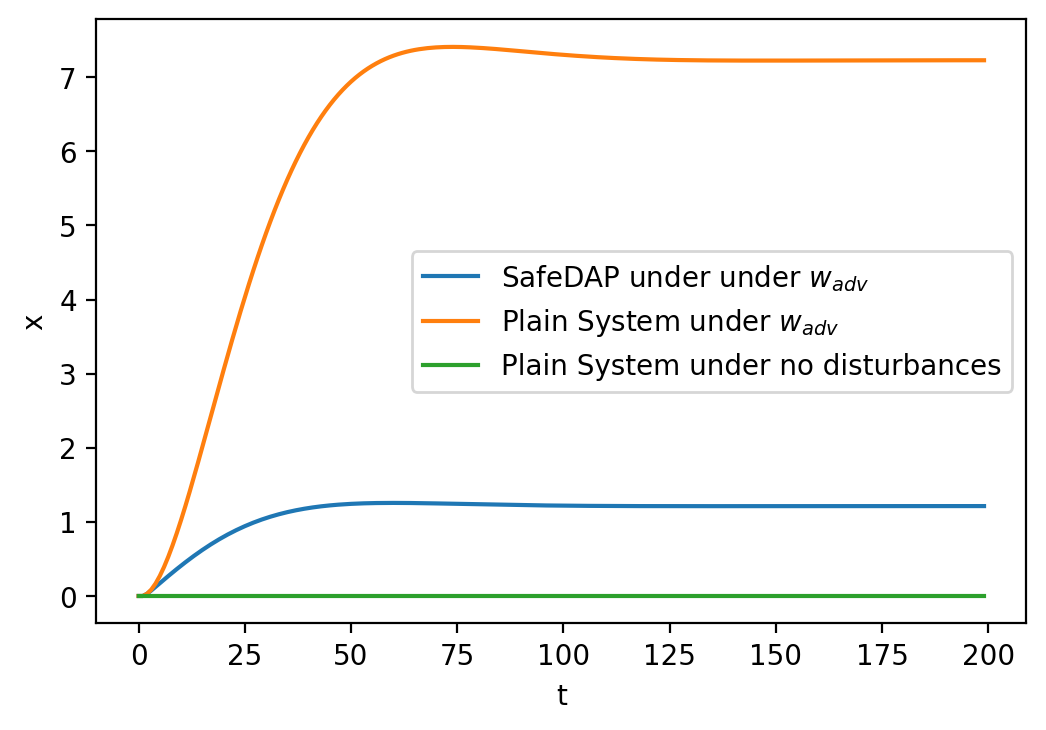

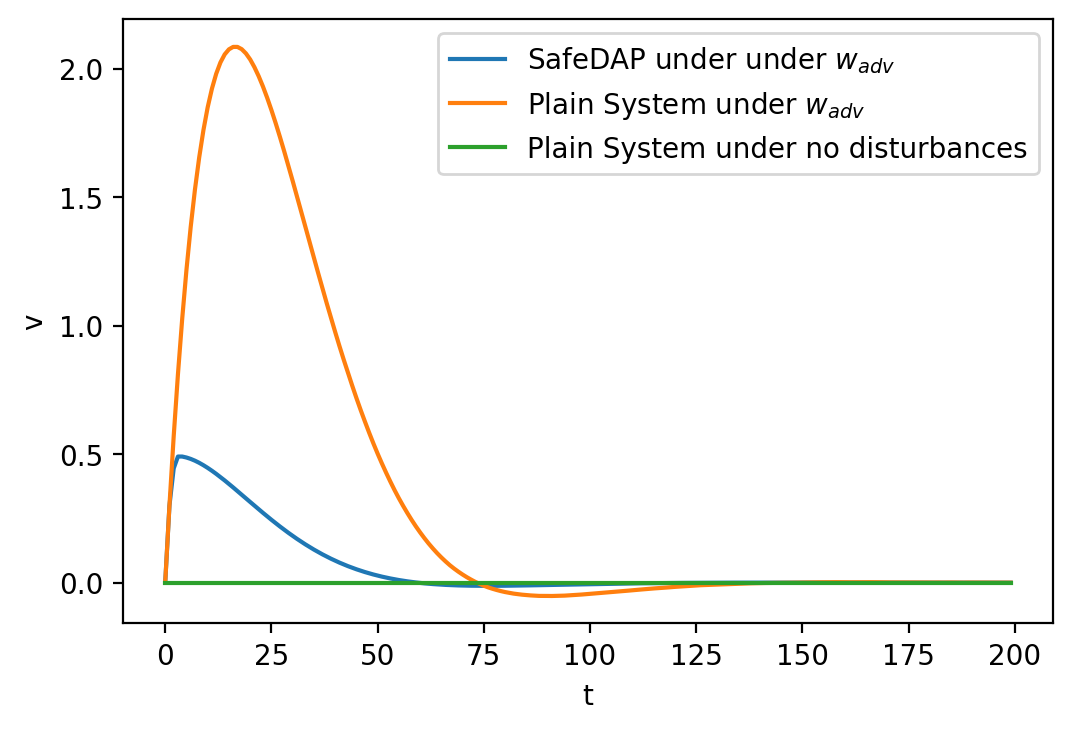

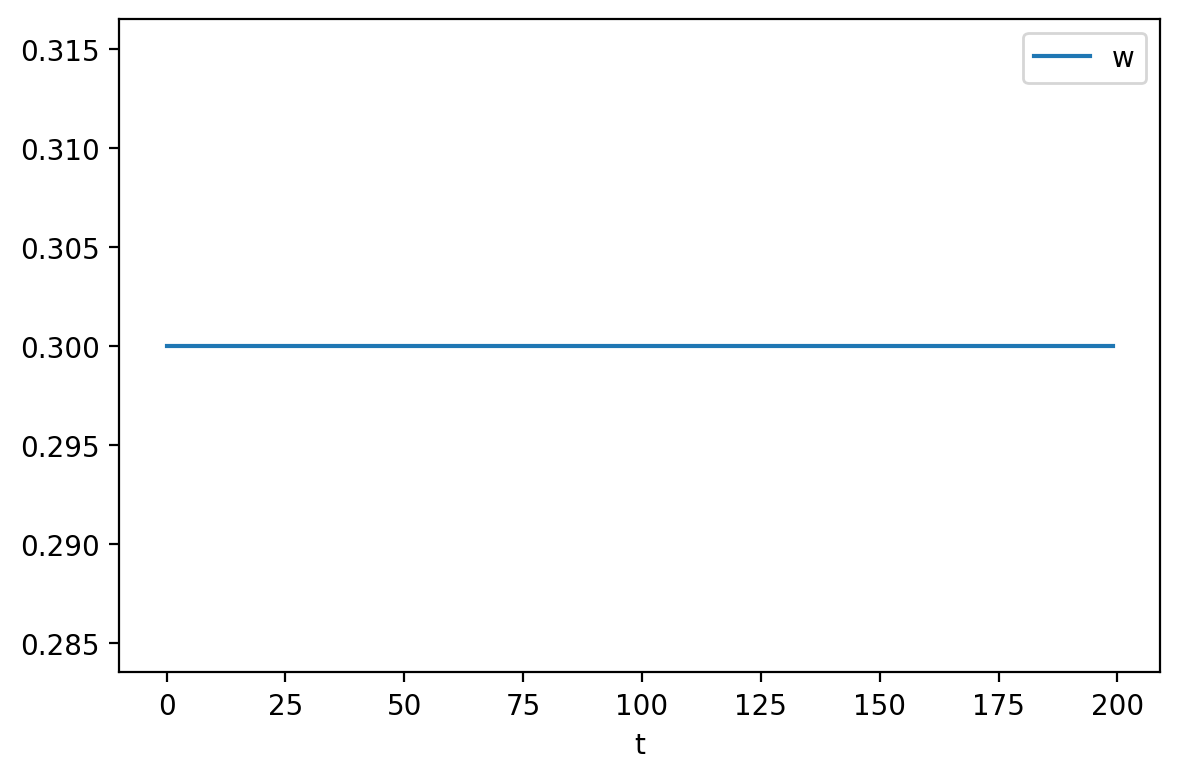

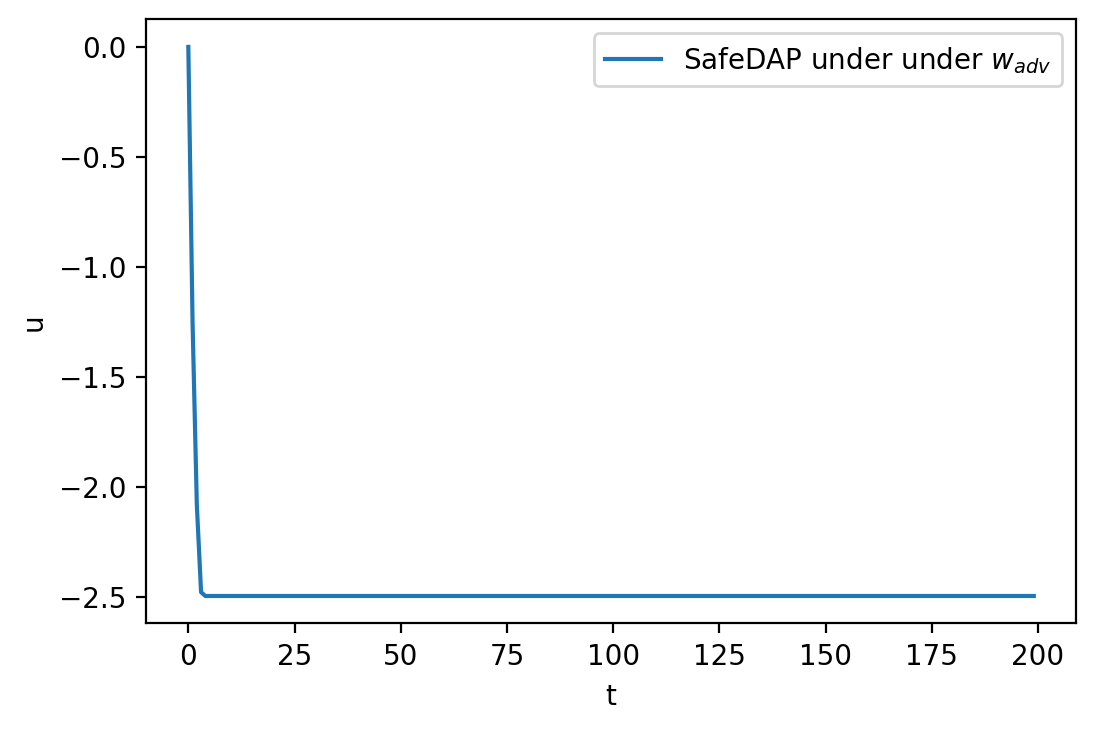

In [8]:
plt.figure(dpi=200)
plt.plot(np.array(x_hist)[:,0],label=r'SafeDAP under under $w_{adv}$')
# plt.plot(np.array(x_hist_rand)[:,0],label=r'SafeDAP under under 100%$w_{rand}$')

plt.plot(np.array(x_no_control_hist)[:,0],label=r'Plain System under $w_{adv}$')

# plt.plot(np.array(x_rand_disturbance)[:,0],label=r'Plain System under 100%$w_{rand}$')

plt.plot(np.array(x_plain)[:,0],label=r'Plain System under no disturbances')
plt.xlabel('t')
plt.ylabel('x')
plt.legend()
plt.savefig('Adv_X.png')

plt.figure(dpi=200)
plt.plot(np.array(x_hist)[:,1],label=r'SafeDAP under under $w_{adv}$')
plt.plot(np.array(x_no_control_hist)[:,1],label=r'Plain System under $w_{adv}$')
# plt.plot(np.array(x_hist_rand)[:,1],label=r'SafeDAP under under 100%$w_{rand}$')


# plt.plot(np.array(x_rand_disturbance)[:,1],label=r'Plain System under 100%$w_{rand}$')

plt.plot(np.array(x_plain)[:,1],label=r'Plain System under no disturbances')
plt.xlabel('t')
plt.ylabel('v')
plt.legend()
plt.savefig('Adv_v.png')

plt.figure(dpi = 200)
# plt.plot(u_hist,label='u')
plt.plot(np.array(w_hist)[10*H:,1],label='w')
plt.legend()

plt.xlabel('t')
plt.tight_layout()
# plt.ylabel('')
plt.savefig('Adv_w.png')

plt.figure(dpi=200)
plt.plot(np.array(u_hist),label=r'SafeDAP under under $w_{adv}$')

plt.xlabel('t')
plt.ylabel('u')
plt.legend()
plt.savefig('Adv_u.png')

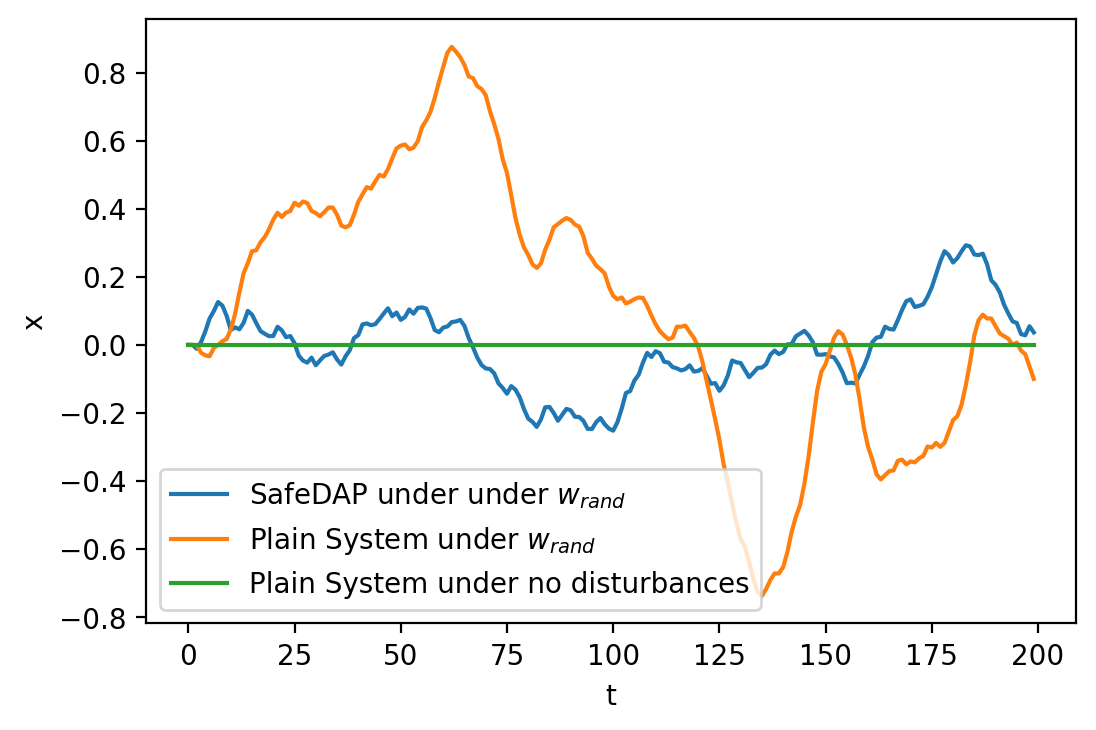

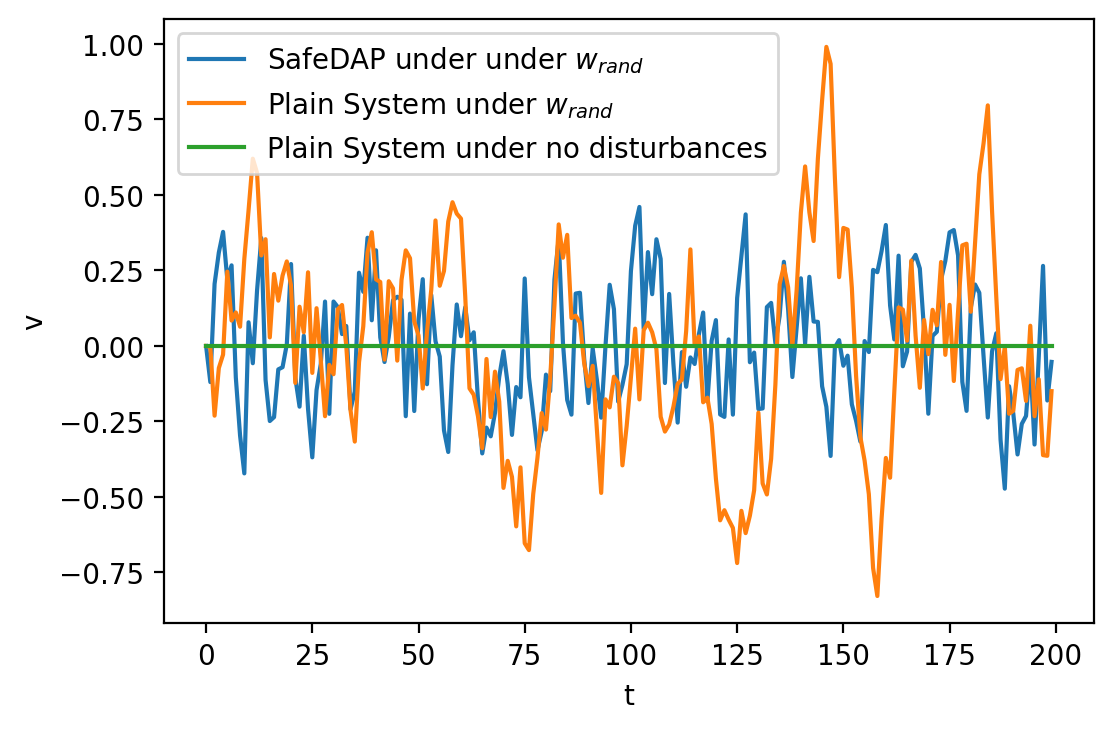

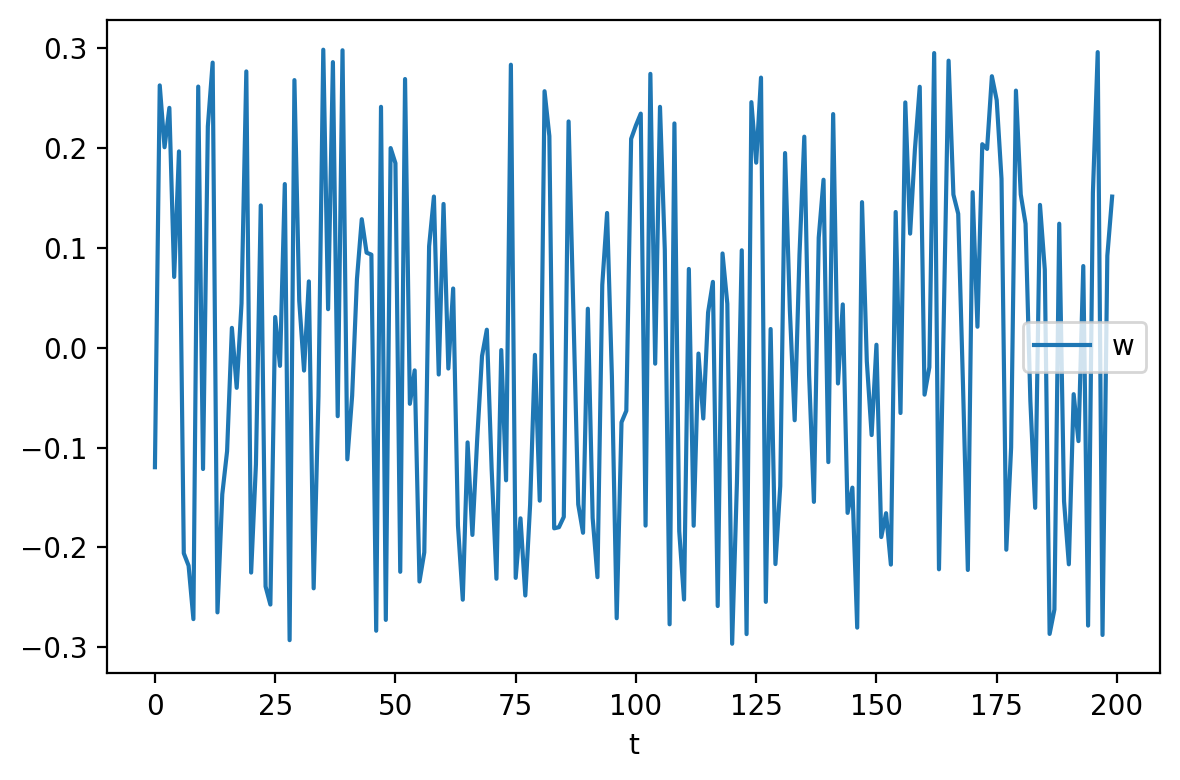

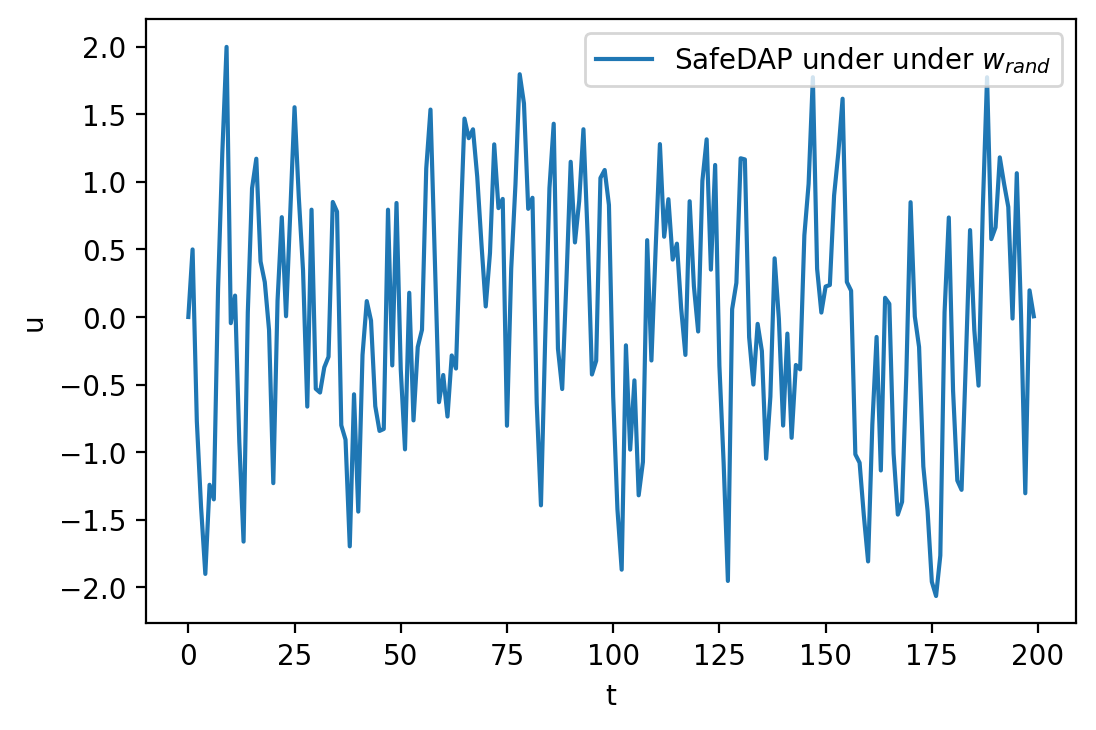

In [9]:
plt.figure(dpi=200)
# plt.plot(np.array(x_hist)[:,0],label=r'SafeDAP under under 99.9%$w_{adv}$+0.1%$w_{rand}$')
plt.plot(np.array(x_hist_rand)[:,0],label=r'SafeDAP under under $w_{rand}$')

# plt.plot(np.array(x_no_control_hist)[:,0],label=r'Plain System under 99.9%$w_{adv}$+0.1%$w_{rand}$')

plt.plot(np.array(x_rand_disturbance)[:,0],label=r'Plain System under $w_{rand}$')

plt.plot(np.array(x_plain)[:,0],label=r'Plain System under no disturbances')
plt.xlabel('t')
plt.ylabel('x')
plt.legend()
plt.savefig('Rand_X.png')

plt.figure(dpi=200)
# plt.plot(np.array(x_hist)[:,1],label=r'SafeDAP under under 99.9%$w_{adv}$+0.1%$w_{rand}$')
# plt.plot(np.array(x_no_control_hist)[:,1],label=r'Plain System under 99.9%$w_{adv}$+0.1%$w_{rand}$')

plt.plot(np.array(x_hist_rand)[:,1],label=r'SafeDAP under under $w_{rand}$')
plt.plot(np.array(x_rand_disturbance)[:,1],label=r'Plain System under $w_{rand}$')

plt.plot(np.array(x_plain)[:,1],label=r'Plain System under no disturbances')
plt.xlabel('t')
plt.ylabel('v')
plt.legend()
plt.savefig('Rand_v.png')

plt.figure(dpi = 200)
# plt.plot(u_hist,label='u')
plt.plot(np.array(w_hist_rand)[10*H:,1],label='w')
plt.legend()

plt.xlabel('t')
plt.tight_layout()
# plt.ylabel('')
plt.savefig('Rand_w.png')

plt.figure(dpi=200)
plt.plot(np.array(u_hist_rand),label=r'SafeDAP under under $w_{rand}$')

plt.xlabel('t')
plt.ylabel('u')
plt.legend()
plt.savefig('Rand_u.png')